# ETL Pipeline Preparation
Follow the instructions below to help you create your ETL pipeline.
### 1. Import libraries and load datasets.
- Import Python libraries
- Load `messages.csv` into a dataframe and inspect the first few lines.
- Load `categories.csv` into a dataframe and inspect the first few lines.

In [66]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine

In [67]:
# load messages dataset
messages = pd.read_csv('../models/messages.csv')
messages.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [68]:
messages.shape

(26248, 4)

In [69]:
messages.isnull().sum()

id              0
message         0
original    16064
genre           0
dtype: int64

In [70]:
# load categories dataset
categories = pd.read_csv('../models/categories.csv')
categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


In [71]:
categories.shape

(26248, 2)

In [72]:
categories.isnull().sum()

id            0
categories    0
dtype: int64

### 2. Merge datasets.
- Merge the messages and categories datasets using the common id
- Assign this combined dataset to `df`, which will be cleaned in the following steps

In [73]:
# merge datasets
df = pd.merge(messages, categories, on='id', how='inner')
df.head()

,id,message,original,genre,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,related-1;request-0;offer-0;aid_related-0;medi...
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,related-1;request-1;offer-0;aid_related-1;medi...
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,related-1;request-0;offer-0;aid_related-0;medi...


In [74]:
df.shape

(26386, 5)

### 3. Split `categories` into separate category columns.
- Split the values in the `categories` column on the `;` character so that each value becomes a separate column. You'll find [this method](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Series.str.split.html) very helpful! Make sure to set `expand=True`.
- Use the first row of categories dataframe to create column names for the categories data.
- Rename columns of `categories` with new column names.

In [75]:
# create a dataframe of the 36 individual category columns
categories = df['categories'].str.split(';', expand=True)
categories.shape

(26386, 36)

In [76]:
# select the first row of the categories dataframe
row = categories.iloc[0]

# use this row to extract a list of new column names for categories.
# one way is to apply a lambda function that takes everything 
# up to the second to last character of each string with slicing
category_colnames = [colname[:-2] for colname in row]
print(category_colnames)

['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


In [77]:
# rename the columns of `categories`
categories.columns = category_colnames
categories.shape

(26386, 36)

### 4. Convert category values to just numbers 0 or 1.
- Iterate through the category columns in df to keep only the last character of each string (the 1 or 0). For example, `related-0` becomes `0`, `related-1` becomes `1`. Convert the string to a numeric value.
- You can perform [normal string actions on Pandas Series](https://pandas.pydata.org/pandas-docs/stable/text.html#indexing-with-str), like indexing, by including `.str` after the Series. You may need to first convert the Series to be of type string, which you can do with `astype(str)`.

In [78]:
for column in categories:
    # set each value to be the last character of the string
    categories[column] = categories[column].str[-1]
    
    # convert column from string to numeric
    categories[column] = pd.to_numeric(categories[column])
categories.shape

(26386, 36)

In [79]:
categories.dtypes

related                   int64
request                   int64
offer                     int64
aid_related               int64
medical_help              int64
medical_products          int64
search_and_rescue         int64
security                  int64
military                  int64
child_alone               int64
water                     int64
food                      int64
shelter                   int64
clothing                  int64
money                     int64
missing_people            int64
refugees                  int64
death                     int64
other_aid                 int64
infrastructure_related    int64
transport                 int64
buildings                 int64
electricity               int64
tools                     int64
hospitals                 int64
shops                     int64
aid_centers               int64
other_infrastructure      int64
weather_related           int64
floods                    int64
storm                     int64
fire    

### 5. Replace `categories` column in `df` with new category columns.
- Drop the categories column from the df dataframe since it is no longer needed.
- Concatenate df and categories data frames.

In [80]:
# drop the original categories column from `df`
df.drop(['categories'], inplace=True, axis=1)
df.shape

(26386, 4)

In [81]:
# concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df, categories], axis=1)
df.shape

(26386, 40)

In [82]:
df.dropna(subset=category_colnames, inplace=True)
df.shape

(26386, 40)

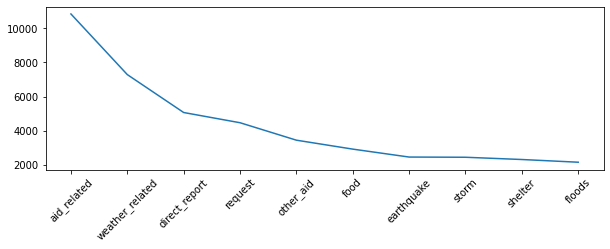

In [100]:
import matplotlib.pyplot as plt

# histogram on categories
hist_data = df.iloc[:, 4:].sum().sort_values(ascending=False)[:10]
plt.figure(figsize=(10,3))
plt.plot(hist_data)
plt.xticks(rotation=45)
plt.show()

In [84]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 6. Remove duplicates.
- Check how many duplicates are in this dataset.
- Drop the duplicates.
- Confirm duplicates were removed.

In [85]:
df.shape

(26386, 40)

In [86]:
import numpy as np
# check number of duplicates
df[df.duplicated(subset='message')].shape[0]

209

In [87]:
# drop duplicates
df.drop_duplicates(subset='message', inplace=True)

In [88]:
# check number of duplicates
df[df.duplicated(subset='message')].shape[0]

0

In [89]:
df.shape

(26177, 40)

In [90]:
df.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,...,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000
mean,15226.345265,0.773580,0.170531,0.004470,0.414104,0.079459,0.050044,0.027658,0.017993,0.032815,...,0.011804,0.043970,0.278336,0.082095,0.093212,0.010773,0.093670,0.020170,0.052565,0.193414
std,8827.039557,0.435345,0.376106,0.066707,0.492576,0.270459,0.218040,0.163994,0.132928,0.178156,...,0.108006,0.205032,0.448188,0.274515,0.290734,0.103234,0.291375,0.140586,0.223168,0.394982
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7449.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15664.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22925.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
df.related.replace(2, 0, inplace=True)

In [92]:
df[df.isna().any(axis=1)]

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
7483,8365,NOTES: It mark as not enough information,NaN,direct,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9956,11186,My thoughts and prayers go out to all the live...,NaN,social,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
9957,11188,I m sorry for the poor people in Haiti tonight...,NaN,social,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
9958,11189,RT selenagomez UNICEF has just announced an em...,NaN,social,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
9959,11192,lilithia yes 5.2 magnitude earthquake hit mani...,NaN,social,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26381,30261,The training demonstrated how to enhance micro...,NaN,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26382,30262,A suitable candidate has been selected and OCH...,NaN,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26383,30263,"Proshika, operating in Cox's Bazar municipalit...",NaN,news,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26384,30264,"Some 2,000 women protesting against the conduc...",NaN,news,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
df.dropna(subset=category_colnames, inplace=True)

### 7. Save the clean dataset into an sqlite database.
You can do this with pandas [`to_sql` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_sql.html) combined with the SQLAlchemy library. Remember to import SQLAlchemy's `create_engine` in the first cell of this notebook to use it below.

In [94]:
df.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,...,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000,26177.000000
mean,15226.345265,0.759216,0.170531,0.004470,0.414104,0.079459,0.050044,0.027658,0.017993,0.032815,...,0.011804,0.043970,0.278336,0.082095,0.093212,0.010773,0.093670,0.020170,0.052565,0.193414
std,8827.039557,0.427568,0.376106,0.066707,0.492576,0.270459,0.218040,0.163994,0.132928,0.178156,...,0.108006,0.205032,0.448188,0.274515,0.290734,0.103234,0.291375,0.140586,0.223168,0.394982
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7449.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15664.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22925.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [95]:
engine = create_engine('sqlite:///DisasterResponseEDA.db')
df.to_sql('messages', engine, index=False, if_exists='replace')

### 8. Use this notebook to complete `etl_pipeline.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database based on new datasets specified by the user. Alternatively, you can complete `etl_pipeline.py` in the classroom on the `Project Workspace IDE` coming later.